***Learning Rectangles***

In this post, we explore a basic computational learning problem; learning rectangles from data. Exploring this problem and the proposed solution provides a first look into the tradeoffs between data, accuracy and confidence.

This post also pairs a theorerical and exprimental exploration of the problem. By pairing theoretical work with visualizations and the instructions (code) for generating data and calculating experimental quantities, we hope to gain a deeper understanding of the tradeoffs in the rectangle learning problem and of the flavor of algorithmic proofs with probabilistic error gaurantees.

***Python Setup***

We begin by importing some modules and defining some helper functions.

In [122]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
fig = plt.figure()
def setup_fig(fig):
    axes = fig.add_subplot(111)
    axes.set_xlim([0, 10])
    axes.set_ylim([0,10])
    return axes

def reset_fig(fig):
    fig.clear()

**Problem Setup**

Consider a distribution **D** that returns two dimensional points from coordinates within a length-10 square. For now, lets assume this distribution is uniform over the sample space. We draw **m** samples from this space.

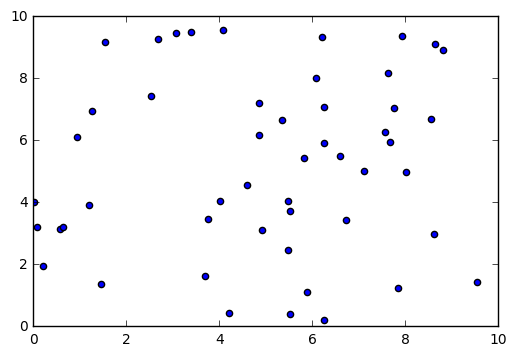

In [148]:
reset_fig(fig)
axes = setup_fig(fig)

m = 50
x, y = np.random.uniform(0, 10, m), np.random.uniform(0, 10, m)
plt.scatter(x, y)
fig

Now let's assume that there is rectanle **R** that exists in this coordinate space. Further, all points generated by the distribution **D** are are classified as positive if they exist in the interior of the rectangle, and classified as negative otherwise.

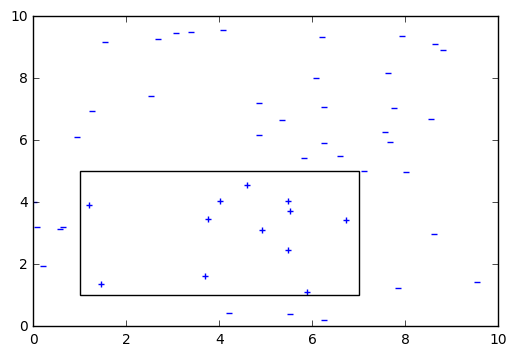

In [149]:
reset_fig(fig)
axes = setup_fig(fig)

# Determine Rectangle

x_corner, y_corner = 1, 1
width, height = 6, 4

# Classify Points

def within_rectangle(x_corner, y_corner, width, height, x, y):
    return x_corner < x < x_corner + width and y_corner < y < y_corner + height 

pos_x, pos_y = zip(*[(x, y) for x, y in zip(x, y) if within_rectangle(x_corner, y_corner, width, height, x, y)])
neg_x, neg_y = zip(*[(x, y) for x, y in zip(x, y) if not within_rectangle(x_corner, y_corner, width, height, x, y)])

# Plot

def add_rect(axes, x, y, width, height):
    axes.add_patch(
        patches.Rectangle(
            (x, y),
            width,
            height,
            fill=False      # remove background
        )
    )
    return

plt.scatter(pos_x, pos_y, marker='+')
plt.scatter(neg_x, neg_y, marker='_')
add_rect(axes, x_corner, y_corner, width, height)
fig

***Goal***

Our goal is to produce a hypothesis for the rectangle **R**, and to understand the relationship between the sample size, the probability of misclassifying future points under the distribution **D**, and our confidence in our hypothesis.

**Proposed Solution**

[Fill in]

NOTE TO SELF:
It is important to remember that
- Once a hypothesis is chosen, \epsilon is fixed and has nothing to do with a particular sample (except that hypothesis was chosen based on examples). But technically, the error is a function of a hypothesis, independent of the sample. E.i. a function that computes the error would not take in the samples as input.
- \delta is the probability that the hypothesis, chosen by the algorithm based samples from the distribution, will be a good hypothesis, given the distribution. While this is based on the distribution D, it may also be interesting/helpful to think as \delta as based on the distrbution of _samples_ of D. To calculate: take the set of possible samples and add up the probabilities of the samples which produce error less than \epsilon.

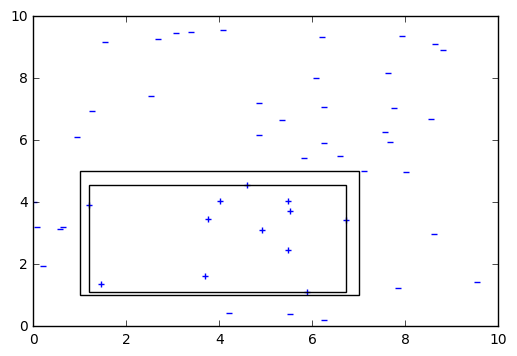

In [150]:
min_x, min_y = min(pos_x), min(pos_y)
guess_width, guess_height = max(pos_x) - min_x, max(pos_y) - min_y

add_rect(axes, min_x, min_y, guess_width, guess_height)
fig

***TODO***
- Sliders for adjusting sample size
- Choose multiple distributions
- Continue with classic proof for "tightest-rectangle" hypothesis
    - Include visualizations for weight of error under distribution
    - Include sliders for \epsilon and radio buttons for Distribution to see how it effects visuals and experimental computations.